<a href="https://colab.research.google.com/github/sheepjun96/Hands_On-Maching-Learning/blob/main/12%EC%9E%A5_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EB%A5%BC_%EC%82%AC%EC%9A%A9%ED%95%9C_%EC%82%AC%EC%9A%A9%EC%9E%90_%EC%A0%95%EC%9D%98_%EB%AA%A8%EB%8D%B8%EA%B3%BC_%ED%9B%88%EB%A0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

# 12.2 넘파이처럼 텐서플로 사용하기

# 텐서 및 연산

In [10]:
import tensorflow as tf

In [11]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]]) # 행렬
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [12]:
t.shape

TensorShape([2, 3])

In [13]:
t.dtype

tf.float32

In [14]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [15]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

In [16]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [17]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [18]:
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

In [20]:
# 스칼라
tf.constant(42)

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [22]:
# 케라스의 저수준 API
K = tf.keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

케라스는 더 이상 멀티 백엔드를 지원하지 않는다.

# 텐서와 넘파이

In [23]:
import numpy as np

a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [24]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [25]:
np.array(t)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [26]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [27]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

# 타입 변환

In [28]:
try:
    tf.constant(2.0) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2] name: 


In [29]:
try:
    tf.constant(2.0) + tf.constant(40., dtype=tf.float64)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2] name: 


In [30]:
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

# 변수

In [35]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [36]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [37]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [38]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [39]:
v.scatter_nd_update(
    indices=[[0, 0], [1, 2]], updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

# 12.3 사용자 정의 모델과 훈련 알고리즘

# 사용자 정의 손실 함수

In [40]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

In [41]:
import matplotlib.pyplot as plt

In [45]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
z_center = np.linspace(-1, 1, 200)

<Figure size 800x350 with 0 Axes>

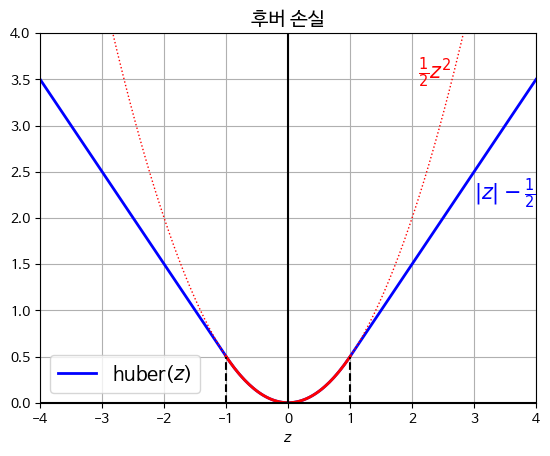

In [46]:
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z ** 2 / 2, "r:", linewidth=1)
plt.plot(z_center, z_center ** 2 / 2, "r", linewidth=2)
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "k--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "k--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.text(2.1, 3.5, r"$\frac{1}{2}z^2$", color="r", fontsize=15)
plt.text(3.0, 2.2, r"$|z| - \frac{1}{2}$", color="b", fontsize=15)
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("후버 손실", fontsize=14)
plt.show()

In [47]:
# 캘리포니아 주택 데이터셋을 로드, 분할 및 스케일을 조정한 다음 간단한 케라스 모델로 훈련

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [49]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [51]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [52]:
input_shape = X_train.shape[1:]
input_shape

(8,)

In [53]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [54]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [55]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 4s 6ms/step - loss: 0.5385 - mae: 0.8961 - val_loss: 0.2920 - val_mae: 0.6062
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.2562 - mae: 0.5638 - val_loss: 0.2115 - val_mae: 0.5021


# 사용자 정의 요소를 가진 모델을 저장하고 로드하기

In [58]:
model.save("my_model_with_a_custom_loss")
# 정상적으로 저장된다.

In [59]:
model = tf.keras.models.load_model("my_model_with_a_custom_loss",
                                   custom_objects={"huber_fn": huber_fn})

In [60]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 4s 6ms/step - loss: 0.2069 - mae: 0.4948 - val_loss: 0.1779 - val_mae: 0.4529
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.1853 - mae: 0.4640 - val_loss: 0.1897 - val_mae: 0.4646


In [61]:
# 다른 기준이 필요할 때는 매개변수를 받을 수 있는 함수를 만드는 것이다.

def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [62]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [67]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 5ms/step - loss: 0.1881 - mae: 0.4418 - val_loss: 0.1824 - val_mae: 0.4295
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.1866 - mae: 0.4387 - val_loss: 0.2178 - val_mae: 0.4529


In [68]:
model.get_metrics_result()

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.21780586>,
 'mae': <tf.Tensor: shape=(), dtype=float32, numpy=0.4528551>}

In [70]:
# threshold 값은 저장되지 않는다.
# tf.keras.losses.Loss 클래스를 상속하고 get_config() 매서드를 구현하면 된다.

class HuberLoss(tf.keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [75]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [76]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [77]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 5ms/step - loss: 0.9461 - mae: 1.0508 - val_loss: 0.3712 - val_mae: 0.6223
Epoch 2/2
363/363 [==============================] - 2s 7ms/step - loss: 0.2890 - mae: 0.5615 - val_loss: 0.2605 - val_mae: 0.5184


In [78]:
model.save("my_model_with_a_custom_loss_class")

In [79]:
model = tf.keras.models.load_model("my_model_with_a_custom_loss_class",
                                   custom_objects={"HuberLoss": HuberLoss})

In [80]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 5s 8ms/step - loss: 0.2320 - mae: 0.4959 - val_loss: 0.2202 - val_mae: 0.4655
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.2080 - mae: 0.4671 - val_loss: 0.1948 - val_mae: 0.4508


In [81]:
model.loss.threshold

2.0

# 활성화 함수, 초기화, 규제, 제한을 커스터마이징하기

In [82]:
def my_softplus(z):
    return tf.math.log(1.0 + tf.exp(z))

In [83]:
def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

In [84]:
def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

In [85]:
def my_positive_weights(weights):
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [86]:
layer = tf.keras.layers.Dense(1, activation=my_softplus,
                              kernel_initializer=my_glorot_initializer,
                              kernel_regularizer=my_l1_regularizer,
                              kernel_constraint=my_positive_weights)

In [87]:
# 사용자 정의 요소가 포함된 모델을 빌드, 훈련, 저장, 로드, 훈련
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1, activation=my_softplus,
                          kernel_initializer=my_glorot_initializer,
                          kernel_regularizer=my_l1_regularizer,
                          kernel_constraint=my_positive_weights)
])
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 4s 6ms/step - loss: 1.3781 - mae: 0.7869 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.7470 - mae: 0.5696 - val_loss: inf - val_mae: inf


In [88]:
model.save("my_model_with_many_custom_parts")

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'function'>, which may lead to improper serialization.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/regularizers.py:426: UserWarning: The `keras.regularizers.serialize()` API should only be used for objects of type `keras.regularizers.Regularizer`. Found an instance of type <class 'function'>, which may lead to improper serialization.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'function'>, which may lead to improper serialization.
  warnings.warn(


In [89]:
model = tf.keras.models.load_model(
    "my_model_with_many_custom_parts",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    }
)
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 5s 8ms/step - loss: 0.5813 - mae: 0.5168 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 2s 4ms/step - loss: 0.5218 - mae: 0.4924 - val_loss: inf - val_mae: inf


In [90]:
class MyL1Regularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor

    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))

    def get_config(self):
        return {"factor": self.factor}

# 사용자 정의 지표

In [91]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [92]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [93]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 2.8651 - huber_fn: 1.0187
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.8630 - huber_fn: 0.3812


# 스트리밍 지표

진짜 양성 개수와 거짓 양성 개수를 기록하기 정밀도를 계산하기 위해 tf.keras.metrics.Precision 클래스를 이용한다.

In [94]:
precision = tf.keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [95]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

정밀도는 각각 80%와 50%이다. 여기서 50%는 두 번째 배치의 정밀도가 아니라 지금까지 전체 정밀도를 계산한 값이다. 배치마다 점진적으로 업데이트되기 때문에 이를 스트리밍 지표라고 부른다.

In [96]:
# 현재 지표 값
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [98]:
# 진짜 양성과 거짓 양성을 기록한 변수
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [99]:
# 변수 초기화
precision.reset_states()

사용자 정의 스트리밍 지표는 Metric 클래스를 상속한다. 다음 예는 전체 후버 손실과 지금까지 처리한 샘플 수를 기록하는 클래스이다.

결괏값을 요청하면 평균 후버 손실이 반환된다.

In [100]:
class HuberMetric(tf.keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        sample_metrics = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(sample_metrics))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return self.total / self.count

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [101]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]]))

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [102]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [103]:
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [104]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [105]:
m.reset_state()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

In [106]:
# 클래스가 제대로 작동하는지 확인
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [107]:
model.compile(loss=create_huber(2.0), optimizer="nadam",
              metrics=[HuberMetric(2.0)])

In [108]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 3s 3ms/step - loss: 0.8612 - huber_metric_1: 0.8612
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.3016 - huber_metric_1: 0.3016


In [109]:
model.save("my_model_with_a_custom_metric")

In [110]:
model = tf.keras.models.load_model(
    "my_model_with_a_custom_metric",
    custom_objects={
        "huber_fn": create_huber(2.0),
        "HuberMetric": HuberMetric
    }
)

In [111]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 3s 5ms/step - loss: 0.2442 - huber_metric_1: 0.2442
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.2175 - huber_metric_1: 0.2175


In [112]:
model.metrics[-1].threshold

2.0

# 사용자 정의 층

In [113]:
exponential_layer = tf.keras.layers.Lambda(lambda x: tf.exp(x))

In [114]:
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

회귀 모델의 출력에 지수 층을 추가하면 예측할 값이 양수이고 스케일이 매우 다른 경우 유용하다.

In [115]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    tf.keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 3s 7ms/step - loss: 0.6787 - val_loss: 0.3981
Epoch 2/5
363/363 [==============================] - 4s 10ms/step - loss: 0.4373 - val_loss: 0.3648
Epoch 3/5
363/363 [==============================] - 2s 6ms/step - loss: 0.3938 - val_loss: 0.3549
Epoch 4/5
363/363 [==============================] - 3s 7ms/step - loss: 0.4897 - val_loss: 0.8574
Epoch 5/5
162/162 [==============================] - 0s 1ms/step - loss: 0.4551


0.4551078975200653